# DCGAN with SPECTRAL NORMALIZATION

In [0]:
import imageio
import numpy as np
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision.utils as vutils
import time
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path
from torch.optim.optimizer import Optimizer, required
from torch import Tensor
from torch.nn import Parameter
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.gridspec as gridspec
import os

# PARAMETERS

In [0]:
batch_size = 64 
dataset_name = 'MNIST'  # Possible datasets [MNIST, FASHION, LSUN, CELEBA, CIFAR10]
loss = 'bce'            # Possible Loss [BCE, HINGE, WASS]
channels = 1
img_size = (32,32,1)
lr = 2e-4
betas = (.5, .99)
epochs = 12
Z_dim = 128
ngpu = 1

leak = 0.1
w_g = 4
weights_backup = True  #Save weights during training
weights_restore = True #Set to False if want to restart training from zero

In [0]:
if weights_backup: 
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/TESI/TESI GAN/Maffione/Colab/DCGAN basic/Spectral Norm/'
  image_path = path + 'images/' + dataset_name 
  checkpoint_file = path + 'weights/checkpt_' + dataset_name + '.pt'
  checkpoint_file_half = path + 'weights/checkpt_' + dataset_name + '-' + str(int(epochs/2)) + '.pt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
print(checkpoint_file)

/content/drive/My Drive/TESI/TESI GAN/Maffione/Colab/DCGAN basic/Spectral Norm/weights/checkpt_MNIST.pt


# DATA LOADER

Dataset MNIST contains 60000 images


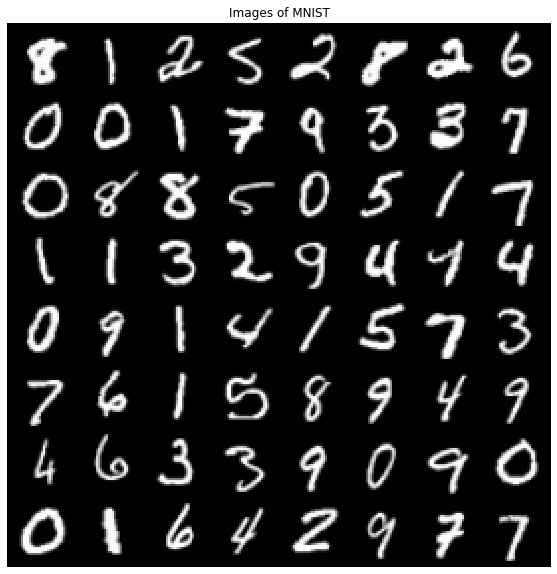

In [0]:
transform=transforms.Compose([
                               transforms.Resize(img_size[0]),
                               #transforms.CenterCrop(img_size[0]),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5])
                               ])

if dataset_name == 'CIFAR10':
  dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
elif dataset_name == 'LSUN':
  dataset = datasets.LSUN(root='./data',classes=['bedroom_train'], transform=transforms)
elif dataset_name== 'CELEBA':
  dataset = datasets.CelebA(root='./data', download=True, transform=transform)
elif  dataset_name== 'MNIST':
  dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
elif  dataset_name== 'FASHION':
  dataset = datasets.FashionMNIST(root='./data', download=True, transform=transform)


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Images of {}".format(dataset_name))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

print('Dataset {} contains {} images'.format(dataset_name, len(dataset)))

## SPECTRAL NORMALIZATION

In [0]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

# MODELS

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, channels, 3, stride=1, padding=(1,1)),
            nn.Tanh())

    def forward(self, z):
        return self.model(z.view(-1, self.z_dim, 1, 1))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = SpectralNorm(nn.Conv2d(channels, 64, 3, stride=1, padding=(1,1)))
        self.conv2 = SpectralNorm(nn.Conv2d(64, 64, 4, stride=2, padding=(1,1)))
        self.conv3 = SpectralNorm(nn.Conv2d(64, 128, 3, stride=1, padding=(1,1)))
        self.conv4 = SpectralNorm(nn.Conv2d(128, 128, 4, stride=2, padding=(1,1)))
        self.conv5 = SpectralNorm(nn.Conv2d(128, 256, 3, stride=1, padding=(1,1)))
        self.conv6 = SpectralNorm(nn.Conv2d(256, 256, 4, stride=2, padding=(1,1)))
        self.conv7 = SpectralNorm(nn.Conv2d(256, 512, 3, stride=1, padding=(1,1)))

        self.fc = SpectralNorm(nn.Linear(w_g * w_g * 512, 1))

    def forward(self, x):
        m = x
        m = nn.LeakyReLU(leak)(self.conv1(m))
        m = nn.LeakyReLU(leak)(self.conv2(m))
        m = nn.LeakyReLU(leak)(self.conv3(m))
        m = nn.LeakyReLU(leak)(self.conv4(m))
        m = nn.LeakyReLU(leak)(self.conv5(m))
        m = nn.LeakyReLU(leak)(self.conv6(m))
        m = nn.LeakyReLU(leak)(self.conv7(m))

        return self.fc(m.view(-1,w_g * w_g * 512))


discriminator = Discriminator().cuda()
generator = Generator(Z_dim).cuda()

print(discriminator)
print(generator)

Discriminator(
  (conv1): SpectralNorm(
    (module): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): SpectralNorm(
    (module): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv3): SpectralNorm(
    (module): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): SpectralNorm(
    (module): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv5): SpectralNorm(
    (module): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv6): SpectralNorm(
    (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv7): SpectralNorm(
    (module): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc): SpectralNorm(
    (module): Linear(in_features=8192, out_features=1, bias=True)
  )
)
Generator(
  (model): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNo

# GAN MODEL

In [0]:
class GAN():
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer, g_scheduler, d_scheduler,
                 critic_iterations=5, use_cuda=True):
      
        self.G = generator
        self.G_opt = gen_optimizer
        self.D = discriminator
        self.D_opt = dis_optimizer
        self.losses = {'G': [], 'D': []}
        self.start_epoch = 0
        self.use_cuda = use_cuda
        self.critic_iterations = critic_iterations
        self.training_progress_images = []
        self.D_scheduler = d_scheduler
        self.G_scheduler = g_scheduler
        self.fixed_z =  Variable(torch.randn(batch_size, Z_dim).cuda())

        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

    def train_epoch(self,data_loader, epoch):
        for batch_idx, (data, target) in enumerate(data_loader):
            if data.size()[0] != batch_size:
                continue
            data, target = Variable(data.cuda()), Variable(target.cuda())

            # update discriminator
            for _ in range(self.critic_iterations):
                z = Variable(torch.randn(batch_size, Z_dim).cuda())
                self.D_opt.zero_grad()
                self.G_opt.zero_grad()

                if loss == 'hinge':
                    d_loss = nn.ReLU()(1.0 - self.D(data)).mean() + nn.ReLU()(1.0 + self.D(self.G(z))).mean()
                elif loss == 'wasserstein':
                    d_loss = -self.D(data).mean() + self.D(self.G(z)).mean()
                else:
                    d_loss = nn.BCEWithLogitsLoss()(self.D(data), Variable(torch.ones(batch_size, 1).cuda())) + \
                                nn.BCEWithLogitsLoss()(self.D(self.G(z)), Variable(torch.zeros(batch_size, 1).cuda()))

                d_loss.backward()
                self.D_opt.step()

                self.losses['D'].append(d_loss.data.item())

            z = Variable(torch.randn(batch_size, Z_dim).cuda())

            # update generator
            self.D_opt.zero_grad()
            self.G_opt.zero_grad()
            
            if loss == 'hinge' or loss == 'wasserstein':
                g_loss = -self.D(self.G(z)).mean()
            else:
                g_loss = nn.BCEWithLogitsLoss()(self.D(self.G(z)), Variable(torch.ones(batch_size, 1).cuda()))

            g_loss.backward()
            self.G_opt.step()

            self.losses['G'].append(g_loss.data.item())
         
        self.D_scheduler.step()
        self.G_scheduler.step()

        print("[%d/%d]\tD_loss: %.2f,\tG_loss: %.2f" % (epoch, epochs, self.losses['D'][-1], self.losses['G'][-1]) )
        self.evaluate(epoch)

    def train(self, data_loader, epochs):
      
        if weights_restore:
          self.restore_checkpoint(checkpoint_file)
         
        print('###########   TRAINING STARTED  ############')
        start = time.time()

        for epoch in range(epochs-self.start_epoch):
            epoch+=self.start_epoch

            self.train_epoch(data_loader, epoch)    
            
            if weights_backup and epoch % 2 == 0:
                self.store_checkpoint(epoch, checkpoint_file)

            #Save a checkpoint also at half of the training
            if weights_backup and epoch == (int(epochs/2)):
              self.store_checkpoint(epoch, checkpoint_file_half)

        end = time.time()
        print('Total training time: {} min, {} sec '.format(int((end - start) / 60), int((end - start) % 60)))
      
        #Save GIF
        imageio.mimsave(image_path+'_GIF_{}epochs.gif'.format(epochs),self.training_progress_images)
  
        #Save and Plot final results
        self.plot_save_generated(epoch, save=True)
        self.plot_save_losses()
    
    def evaluate(self, epoch):
        img_grid = make_grid(self.G(self.fixed_z).cpu().data).numpy()       # Generate batch of images and convert to grid
        img_grid = img_grid.transpose((1, 2, 0)) * 0.5 + 0.5   # Convert to numpy and transpose axes to fit imageio convention i.e. (width, height, channels)
        self.training_progress_images.append(img_grid)         # Add image grid to training progress        
        self.plot_epoch(epoch, img_grid)
       
    def plot_epoch(self, epoch, img_grid):
        plt.figure(figsize=(7,7))
        plt.imshow(img_grid)
        plt.axis('off')
        plt.title('Generated images after epoch {}'.format((epoch+1)))
        plt.show()

    def plot_save_generated(self, epoch=epochs, save=False):
        latents = Variable(torch.randn(batch_size, Z_dim).cuda())
        img = make_grid(self.G(latents).cpu().data).numpy() 
        img = img.transpose((1, 2, 0)) * 0.5 + 0.5
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Generated images after {} epochs'.format((epoch+1)))
        if save:
          plt.savefig(image_path + '_generated_%d.png' % (epoch+1))
        plt.show()
        
    def plot_save_losses(self):
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Losses During Training")
        plt.plot(self.losses['G'],label="G")
        plt.plot(self.losses['D'],label="D")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(image_path + '_losses.png')
        plt.show()

    def store_checkpoint(self, epoch, checkpoint_file):
      torch.save({'epoch': epoch,
                  'generator': self.G.state_dict(),
                  'discriminator': self.D.state_dict(),
                  'optimizerG': self.G_opt.state_dict(),
                  'optimizerD': self.D_opt.state_dict(),
                  'loss': self.losses,
                  'fixed_z': self.fixed_z,
                  'images_gen': self.training_progress_images
                  }, checkpoint_file)
        
      print('Saved checkpoint at epoch: ', epoch)

    def restore_checkpoint(self,checkpoint_file):
        if Path(checkpoint_file).exists():
          checkpoint = torch.load(checkpoint_file)
          self.G.load_state_dict(checkpoint['generator'])
          self.D.load_state_dict(checkpoint['discriminator'])
          self.G_opt.load_state_dict(checkpoint['optimizerG'])
          self.D_opt.load_state_dict(checkpoint['optimizerD'])
          self.losses = checkpoint['loss']
          self.fixed_z = checkpoint['fixed_z']
          self.training_progress_images = checkpoint['images_gen']
          self.start_epoch = checkpoint['epoch']
          print('Checkpoint found and restored at epoch {}'.format(self.start_epoch))
        else: 
          print('Checkpoint not used or not exist\n')

# MAIN 

Checkpoint not used or not exist

###########   TRAINING STARTED  ############
[0/12]	D_loss: 0.08,	G_loss: 3.95


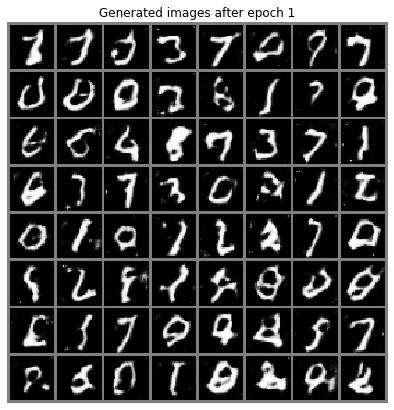

Saved checkpoint at epoch:  0
[1/12]	D_loss: 0.32,	G_loss: 4.46


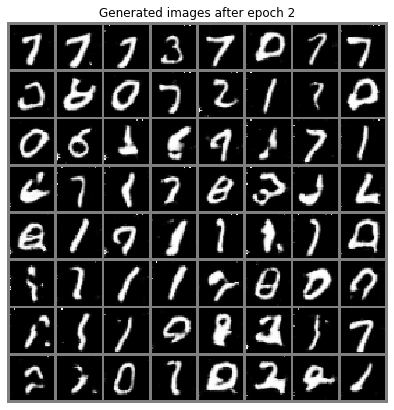

[2/12]	D_loss: 0.10,	G_loss: 3.83


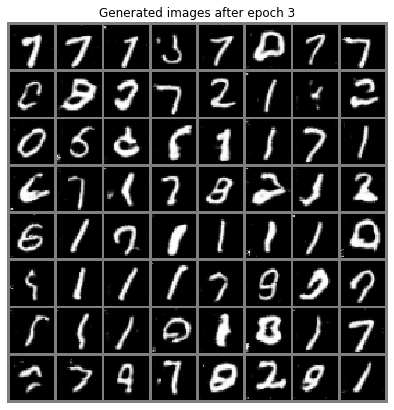

Saved checkpoint at epoch:  2
[3/12]	D_loss: 0.31,	G_loss: 1.57


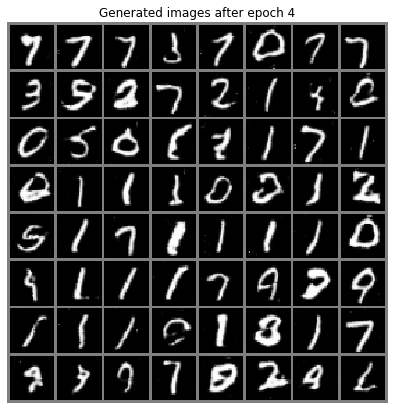

[4/12]	D_loss: 0.34,	G_loss: 1.85


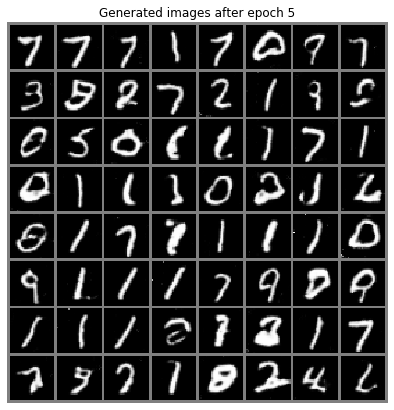

Saved checkpoint at epoch:  4
[5/12]	D_loss: 0.10,	G_loss: 4.19


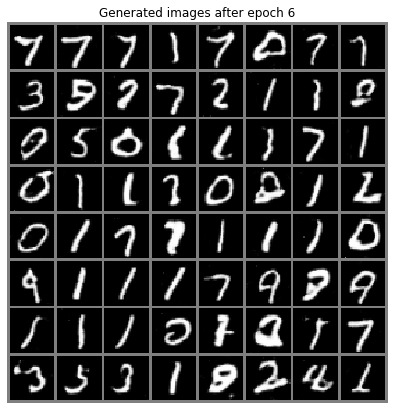

[6/12]	D_loss: 0.08,	G_loss: 3.89


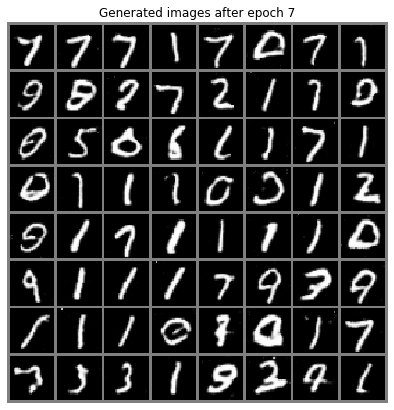

Saved checkpoint at epoch:  6
Saved checkpoint at epoch:  6
[7/12]	D_loss: 0.29,	G_loss: 1.66


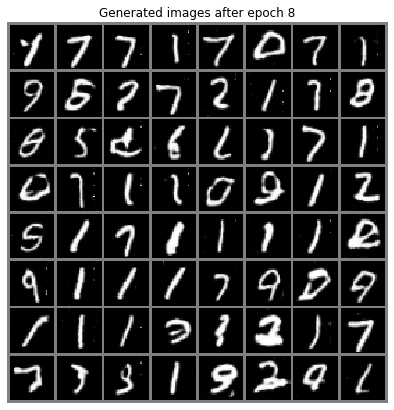

[8/12]	D_loss: 0.17,	G_loss: 2.74


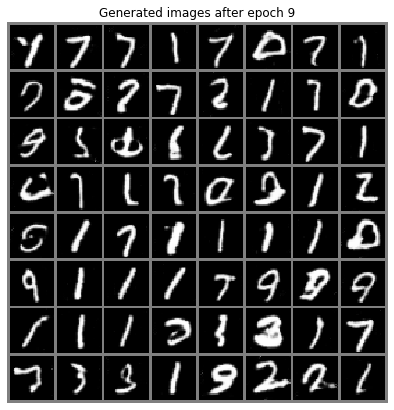

Saved checkpoint at epoch:  8


In [0]:
# Because the spectral normalization module creates parameters that don't require gradients (u and v), we don't want to optimize these using sgd. We only let the optimizer operate on parameters that _do_ require gradients
opt_D = optim.Adam(filter(lambda p: p.requires_grad, discriminator.parameters()), lr=lr, betas=(0.0,0.9))
opt_G  = optim.Adam(generator.parameters(), lr=lr, betas=(0.0,0.9))

# Use an exponentially decaying learning rate
scheduler_d = optim.lr_scheduler.ExponentialLR(opt_D, gamma=0.99)
scheduler_g = optim.lr_scheduler.ExponentialLR(opt_G, gamma=0.99)

model = GAN(generator, discriminator, opt_G, opt_D, scheduler_g, scheduler_d)
model.train(dataloader, epochs)

#Load Model if you don't train
#model.restore_checkpoint(checkpoint_file) 